In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ipywidgets import Button, HBox, VBox, Output
from IPython.display import display
import pickle 
from matplotlib.path import Path
from PIL import Image
import cv2

import glob
import os
import h5py

from utils import get_matrix_points, get_coords


In [16]:
def process_webcam_images(path):
    img = Image.open(path).convert("L")

ROWS, COLS = 18, 18

def get_mirror(m_points, idx, image):
    indices = [(i, j) for i in range(ROWS - 1) for j in range(COLS - 1)]
    N = len(indices)
    state = {'idx': idx}

    x, y = get_coords(state, indices, m_points)

    mirror = extract_polygon_region_cv2_from_image(image, x, y)
    return mirror

def extract_polygon_region_cv2_from_image(img, x_coords, y_coords):
    """
    Extracts a polygonal region from an image and returns it as a new (cropped) image.
    Args:
        img: Input image.
        x_coords, y_coords: Lists of x and y coordinates of polygon vertices.

    Returns:
        Cropped polygon region as a new image.
    """

    # Wczytaj obraz w skali szarości
    # img = np.array(Image.open(img_path).convert('L'))  # -> shape: (H, W), dtype: uint8
    
    # Przekształć punkty wielokąta
    pts = np.array(list(zip(x_coords, y_coords)), dtype=np.int32)
    pts = pts.reshape((-1, 1, 2))
    
    # Maska binarna o tym samym rozmiarze
    mask = np.zeros(img.shape, dtype=np.uint8)
    cv2.fillPoly(mask, [pts], color=255)
    
    # Nałożenie maski
    masked_img = cv2.bitwise_and(img, img, mask=mask)
    
    # Przycięcie do prostokąta ograniczającego
    x, y, w, h = cv2.boundingRect(pts)
    cropped = masked_img[y:y+h, x:x+w]

    return cropped



In [5]:
image_list = glob.glob("/media/pgliwny/ADATA HD330/Computer_Vision_system/data/MAGIC/webcam/image_2024*")
print(image_list[:10])

['/media/pgliwny/ADATA HD330/Computer_Vision_system/data/MAGIC/webcam/image_2024-01-09_1500.jpg', '/media/pgliwny/ADATA HD330/Computer_Vision_system/data/MAGIC/webcam/image_2024-02-01_1800.jpg', '/media/pgliwny/ADATA HD330/Computer_Vision_system/data/MAGIC/webcam/image_2024-02-25_1400.jpg', '/media/pgliwny/ADATA HD330/Computer_Vision_system/data/MAGIC/webcam/image_2024-03-19_1700.jpg', '/media/pgliwny/ADATA HD330/Computer_Vision_system/data/MAGIC/webcam/image_2024-04-12_1100.jpg', '/media/pgliwny/ADATA HD330/Computer_Vision_system/data/MAGIC/webcam/image_2024-05-05_1400.jpg', '/media/pgliwny/ADATA HD330/Computer_Vision_system/data/MAGIC/webcam/image_2024-05-28_1700.jpg', '/media/pgliwny/ADATA HD330/Computer_Vision_system/data/MAGIC/webcam/image_2024-06-21_1200.jpg', '/media/pgliwny/ADATA HD330/Computer_Vision_system/data/MAGIC/webcam/image_2024-01-01_1000.jpg', '/media/pgliwny/ADATA HD330/Computer_Vision_system/data/MAGIC/webcam/image_2024-01-01_1100.jpg']


In [6]:
img = Image.open(image_list[0]).convert("L")

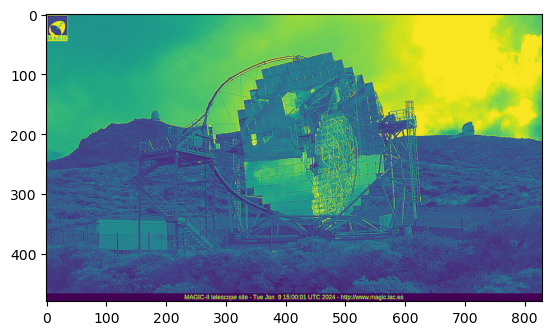

In [7]:
plt.imshow(np.array(img))

In [9]:
m_points = get_matrix_points()

In [10]:
m_points.shape

(18, 18)

In [11]:
m1 = get_mirror(m_points, 280, np.array(img))

289


In [17]:
mirrors_list = [get_mirror(m_points, i, np.array(img)) for i in range(289)]

In [20]:
m1.shape

(16, 17)

In [22]:
np.array(img).shape

(480, 830)

In [23]:
len(mirrors_list)

289

In [24]:
mirrors_list[0].shape

(10, 12)

In [25]:
mirrors_list[1].shape

(13, 17)

In [27]:
image_list[0].split("/")[-1]

'image_2024-01-09_1500.jpg'

In [28]:
image_data = [
    {
        "name":image_list[0].split("/")[-1],
        "image": np.array(img),
        "mirrors": mirrors_list
    }
]

In [30]:
with h5py.File("webcam_images.h5", "w") as f:
    images_group = f.create_group("images")

    for idx, entry in enumerate(image_data):
        entry_group = images_group.create_group(f"entry_{idx}")
        entry_group.create_dataset("image", data=entry["image"])
        entry_group.create_dataset("image_name", data=entry["name"].encode("utf-8"))
        
        mirrors_group = entry_group.create_group("mirrors")
        for m_idx, mirror in enumerate(entry["mirrors"]):
            mirrors_group.create_dataset(f"mirror_{m_idx}", data=mirror)
                                       

In [32]:
with h5py.File("webcam_images.h5", "r") as f:
    for entry_name in f["images"]:
        entry = f["images"][entry_name]
        image = entry["image"][:]
        name = entry["image_name"][()].decode("utf-8")
        
        mirrors = []
        for mirror_name in entry["mirrors"]:
            mirrors.append(entry["mirrors"][mirror_name][:])

        print(f"{name}: image shape {image.shape}, mirrors: {[m.shape for m in mirrors]}")

image_2024-01-09_1500.jpg: image shape (480, 830), mirrors: [(10, 12), (13, 17), (21, 20), (19, 17), (20, 18), (19, 17), (19, 16), (19, 18), (20, 17), (20, 18), (20, 19), (20, 14), (21, 18), (18, 14), (21, 17), (21, 16), (21, 17), (22, 19), (21, 16), (21, 17), (21, 18), (20, 17), (21, 18), (18, 17), (18, 17), (18, 16), (18, 17), (17, 16), (17, 16), (17, 17), (16, 13), (16, 17), (16, 15), (17, 15), (16, 17), (19, 18), (17, 19), (17, 15), (18, 17), (18, 17), (18, 16), (19, 18), (17, 17), (17, 16), (18, 17), (18, 15), (17, 17), (18, 16), (19, 18), (18, 14), (19, 17), (18, 16), (19, 16), (19, 16), (20, 19), (19, 15), (20, 17), (16, 17), (19, 17), (20, 16), (19, 18), (17, 17), (17, 15), (17, 16), (18, 15), (18, 17), (19, 17), (19, 13), (14, 14), (20, 17), (20, 16), (20, 16), (20, 16), (22, 20), (21, 15), (22, 17), (22, 17), (23, 16), (24, 18), (16, 15), (17, 16), (18, 15), (17, 16), (18, 15), (18, 16), (17, 16), (17, 14), (18, 17), (18, 16), (18, 15), (16, 18), (17, 16), (18, 19), (17, 15),